<a href="https://colab.research.google.com/github/Hyerin-oh/code_implementation/blob/main/basic_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi Layer Perceptron 만들어보기

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina' 
device = torch.device('cuda : 0'if torch.cuda.is_available() else 'cpu')



### Dataset 준비(필수)



In [121]:
mnist_train=datasets.MNIST(root='./data/',train=True , transform = transforms.ToTensor() , download=True)
mnist_test=datasets.MNIST(root='./data/',train=False , transform = transforms.ToTensor() , download=True)

Batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train , batch_size = Batch_size,shuffle = True)
test_iter = torch.utils.data.DataLoader(mnist_test , batch_size = Batch_size,shuffle = True)

### training data 시각화

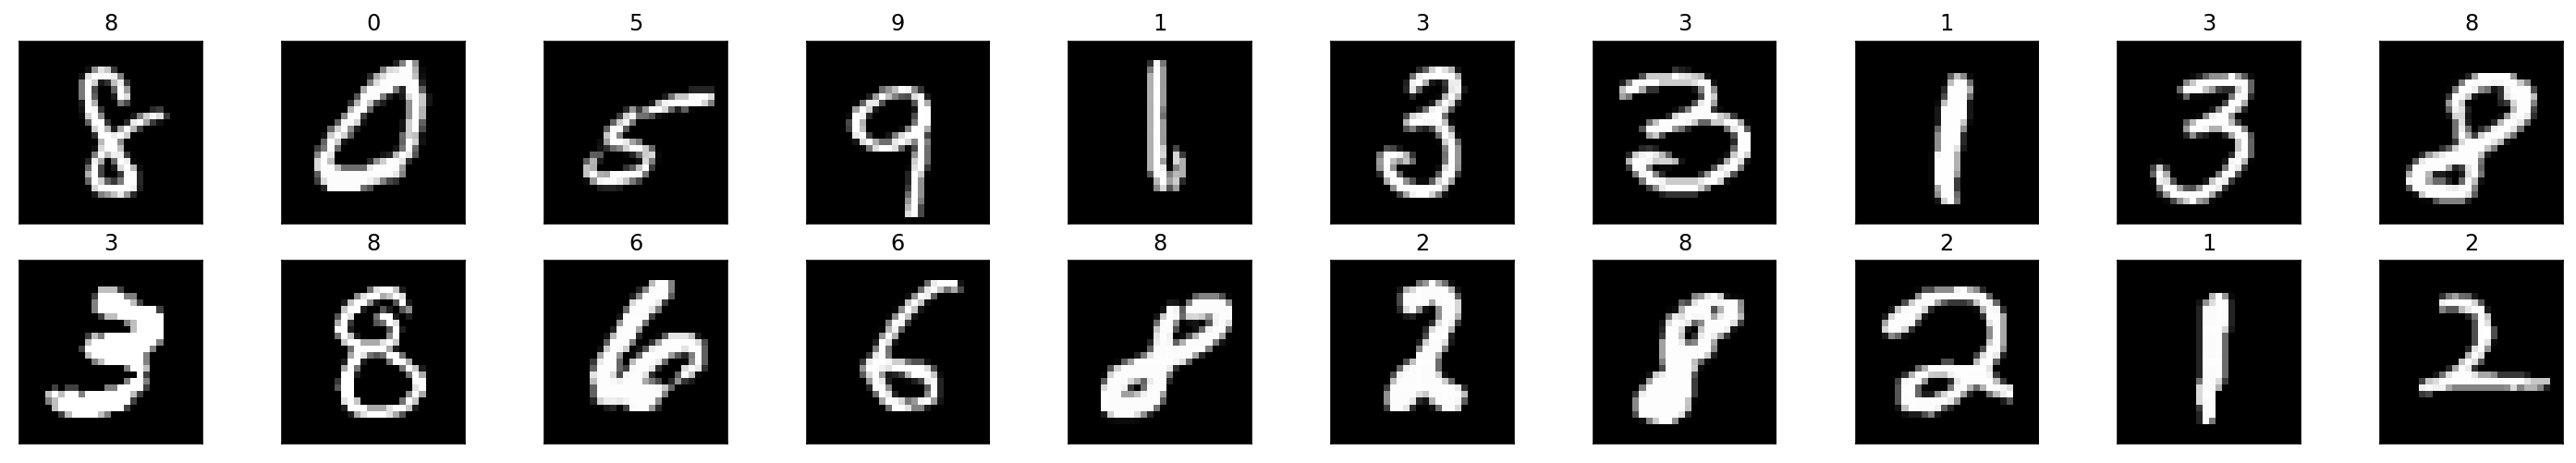

In [122]:
# iteration 형태로 하나하나씩 꺼내봄
dataiter = iter(train_iter)
images , labels = dataiter.next()

fig = plt.figure(figsize = (25,4))
for idx in range(1,21):
    #subplot : nrows , ncols , index  , xticks = [] 라고 써주면 눈금이 안보여용
    plt.subplot(2,10,idx , xticks = [] , yticks = [])
    #images가 c,w,h 순서라서 reshape 해줌 
    plt.imshow(images[idx].reshape(28,28) , cmap ='gray')
    plt.title(labels[idx].item())

### network(필수)

In [123]:
class MultiLayerPerceptronClass(nn.Module):
    def __init__(self,name='mlp'):
        super(MultiLayerPerceptronClass , self).__init__()
        self.name = name
        self.lin1 = nn.Linear(784 , 512)
        self.lin2 = nn.Linear(512 , 256)
        self.lin3 = nn.Linear(256 , 10)
        self.init__params()

    # 필수는 아니지만 파라미터들을 초기화해주는 함수 
    def init__params(self):
        nn.init.kaiming_normal_(self.lin1.weight)
        nn.init.zeros_(self.lin1.weight)
        nn.init.kaiming_normal_(self.lin2.weight)
        nn.init.zeros_(self.lin2.weight)
        nn.init.kaiming_normal_(self.lin3.weight)
        nn.init.zeros_(self.lin3.weight)

    def forward(self, x):
      x = self.lin1(x)
      x = F.relu(x)
      x = self.lin2(x)
      x = F.relu(x)
      x = self.lin3(x)
      return x

#클래스 호출 후, gpu사용을 위해 .to(device)
Model = MultiLayerPerceptronClass().to(device)
print(Model)


MultiLayerPerceptronClass(
  (lin1): Linear(in_features=784, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
)


# loss fuction & optimizer(필수)

In [124]:
#분류 -> 크로스엔트로피로스 사용 
loss = nn.CrossEntropyLoss()
#옵타마이저 -> 아담 사용 
optm = optim.Adam(Model.parameters())

### 파라미터 개수 확인 
###### - sense,,,? 있으면 모델의 크기를 파악할 수 있어 좋다. 굳이 없어도 상관은 없다

In [125]:
np.set_printoptions(precision=3) #3자리수까지 출력 
n_params = 0
for p_idx , (param_name , param) in enumerate(Model.named_parameters()):
    #gpu -> cpu , torch -> numpy , detach : 연산 기록x 
    param_numpy = param.detach().cpu().numpy()
    n_params += len(param_numpy.reshape(-1))
    print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
    print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_params,',d')))

[0] name:[lin1.weight] shape:[(512, 784)].
    val:[0. 0. 0. 0. 0.]
[1] name:[lin1.bias] shape:[(512,)].
    val:[ 0.016  0.005 -0.018  0.    -0.021]
[2] name:[lin2.weight] shape:[(256, 512)].
    val:[0. 0. 0. 0. 0.]
[3] name:[lin2.bias] shape:[(256,)].
    val:[0.028 0.024 0.031 0.035 0.033]
[4] name:[lin3.weight] shape:[(10, 256)].
    val:[0. 0. 0. 0. 0.]
[5] name:[lin3.bias] shape:[(10,)].
    val:[ 0.044  0.036 -0.016 -0.041  0.04 ]
Total number of parameters:[535,818].


### evalutaion fuction & init eval

In [126]:
def func_eval(model, data_iter , device , train = True):
    with torch.no_grad():
      n_total , n_correct = 0,0
      for image , label in data_iter : 
          # mini_batch 내 label = target label
          y_target = label.to(device)
          # mini_batch 내 image를 model에 넣은 결과물 = 예측
          model_pred =  model(image.view(-1,28*28).to(device))
          # dimension 1 기준 , 가장 큰 인덱스와 값 return 
          _, y_pred = torch.max(model_pred.data , 1)
          #tensor(n) 형식으로 뜨기 때문에 .items()
          n_correct += (y_pred == y_target).sum().item()
          n_total += image.size(0)
      val_accr = (n_correct / n_total)
      # 다시 train 모드로 돌아가게 함
    return val_accr

train_accr = func_eval(Model,train_iter,device)
test_accr = func_eval(Model,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.099] test_accr:[0.098].


### Train (필수)

In [127]:
# 파라미터 초기화 후 train
Model.init__params()
Model.train()

epochs = 10
for epoch in range(epochs):
  loss_val_sum = 0
  for image , label in train_iter : 
      #forward path 
      #image = (256,1,1,28,28) -> 28*28 dimension로 바꿔줌
      y_pred = Model.forward(image.view(-1, 28*28).to(device))
      loss_out = loss(y_pred , label.to(device))
      #update & backward
      # 미분을 통해 얻은 grad가 누적되는 것을 방지하기 위해 zero_grad 매번 실행 
      optm.zero_grad()
      #backpropagation
      loss_out.backward()
      # weight upgrade
      optm.step()
      #loss cal
      loss_val_sum += loss_out
  loss_val_avg = loss_val_sum / len(train_iter)

  #확인을 위해 중간중간 출력 
  train_accr = func_eval(Model , train_iter , device )
  val_accr = func_eval(Model , train_iter , device )
  print(f"epochs:{epoch} , loss : {loss_val_avg:.3f} , train_acc:{train_accr:.3f},test_acc:{test_accr:.3f}")

epochs:0 , loss : 1.615 , train_acc:0.773,test_acc:0.098
epochs:1 , loss : 0.334 , train_acc:0.947,test_acc:0.098
epochs:2 , loss : 0.165 , train_acc:0.966,test_acc:0.098
epochs:3 , loss : 0.114 , train_acc:0.976,test_acc:0.098
epochs:4 , loss : 0.087 , train_acc:0.980,test_acc:0.098
epochs:5 , loss : 0.069 , train_acc:0.981,test_acc:0.098
epochs:6 , loss : 0.056 , train_acc:0.988,test_acc:0.098
epochs:7 , loss : 0.043 , train_acc:0.991,test_acc:0.098
epochs:8 , loss : 0.037 , train_acc:0.991,test_acc:0.098
epochs:9 , loss : 0.028 , train_acc:0.994,test_acc:0.098


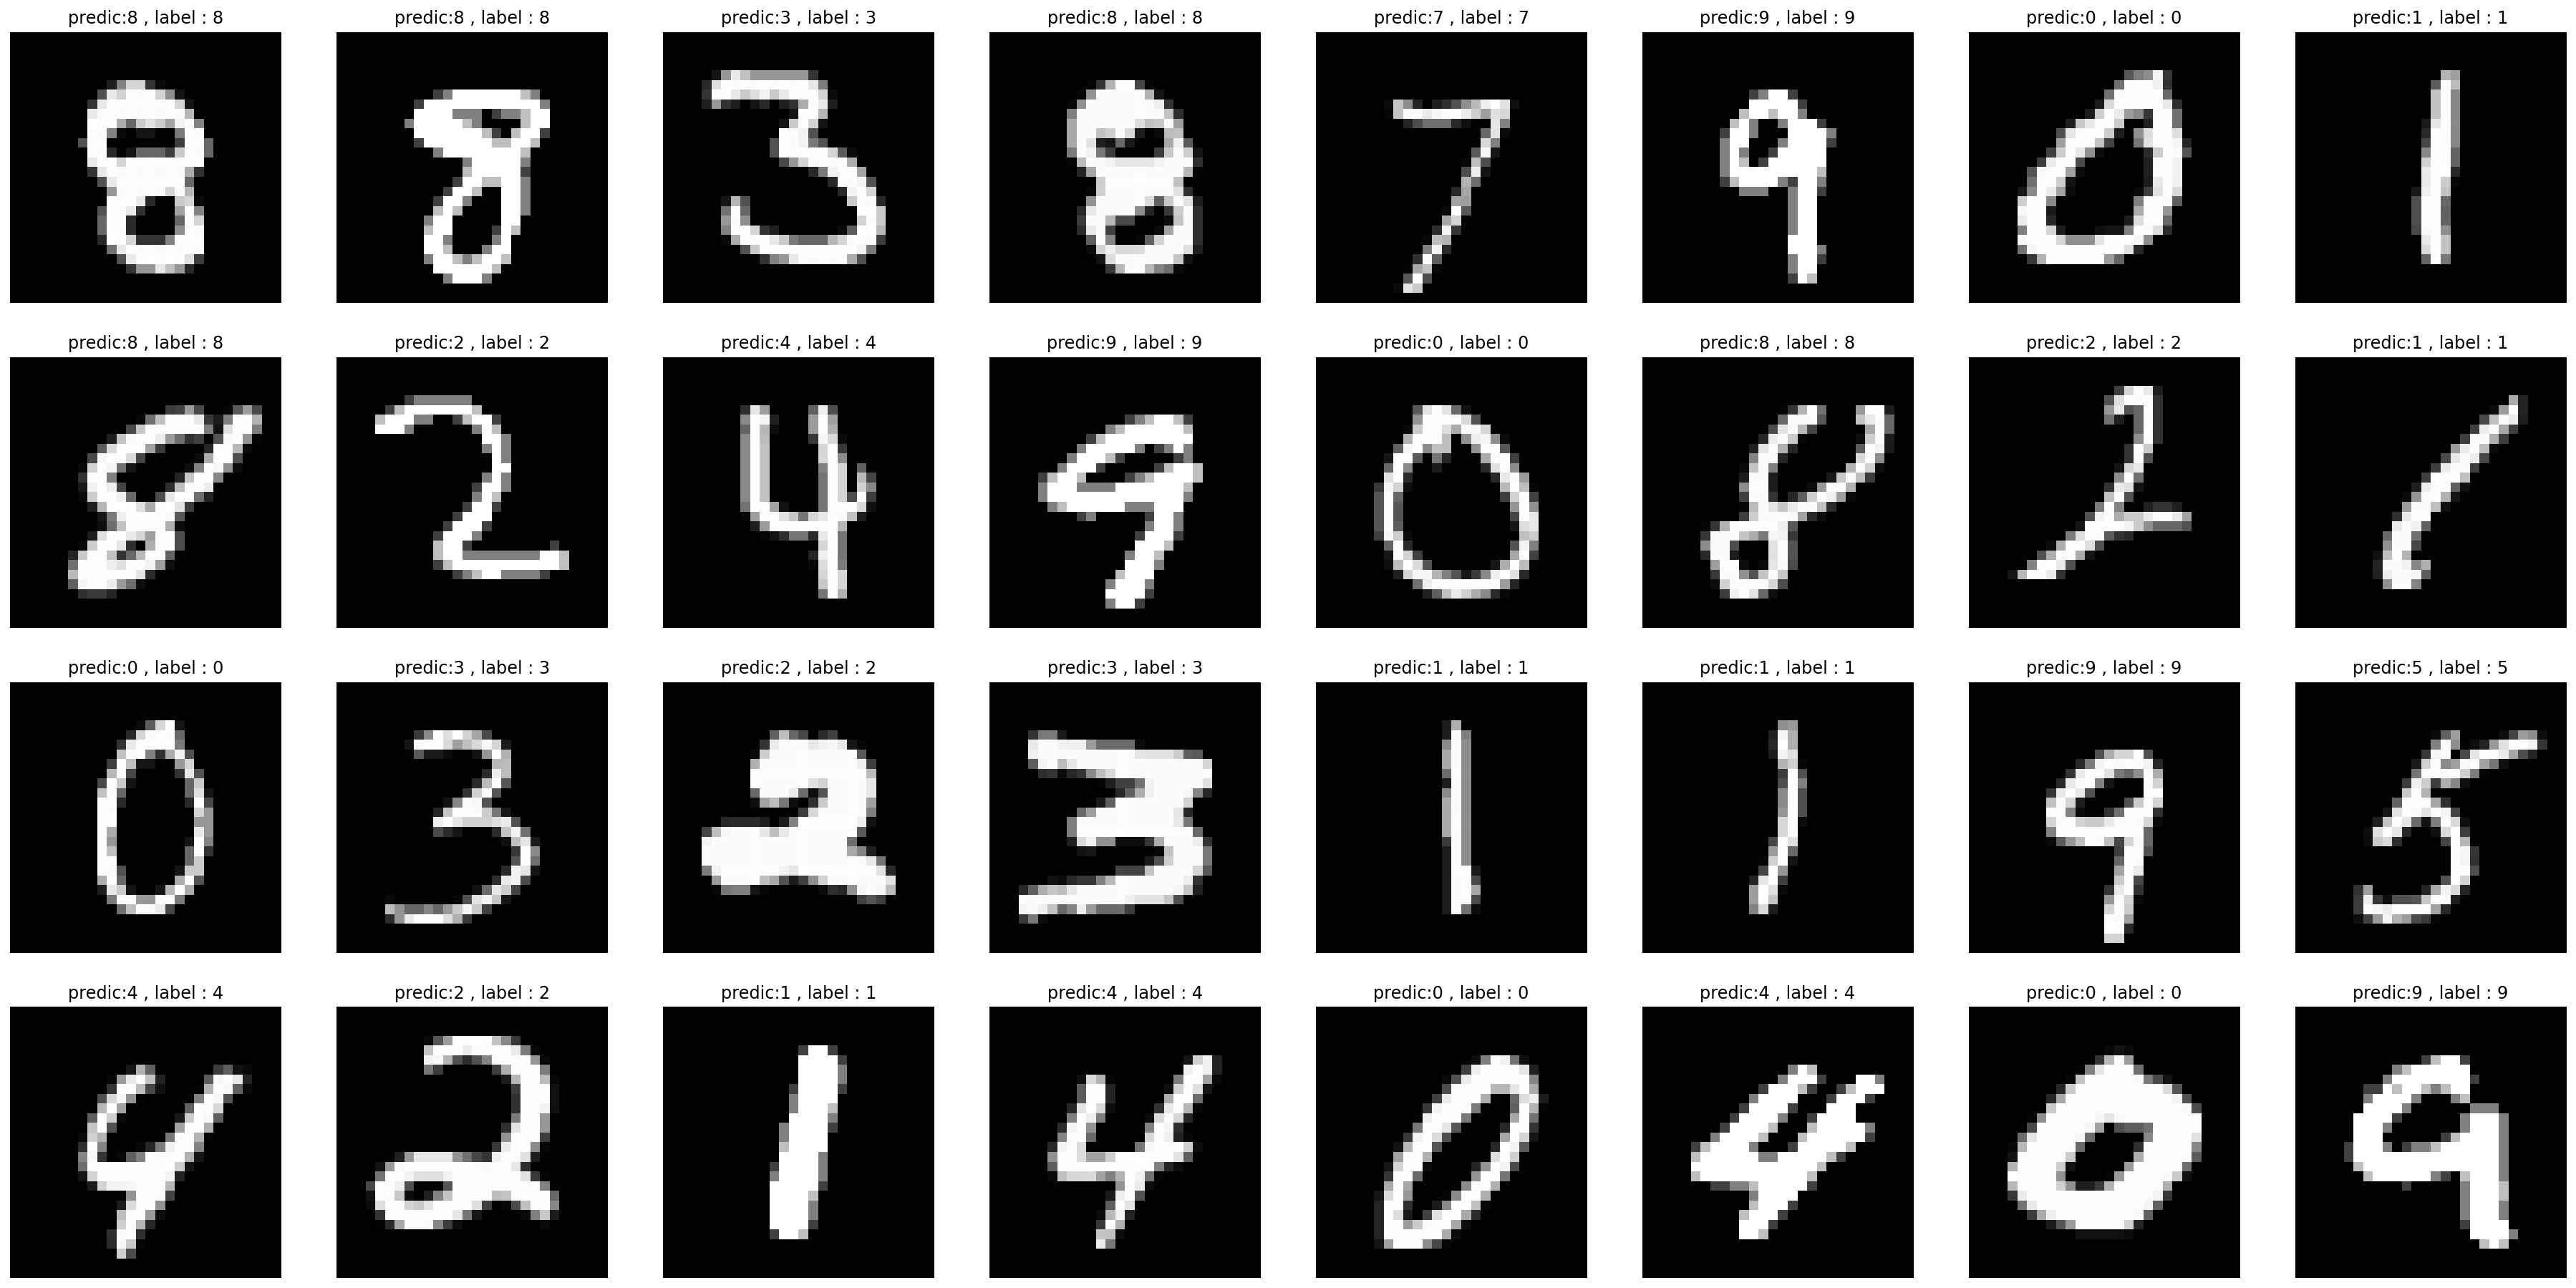

In [128]:
n_sample = 32
sample_index = np.random.choice(len(mnist_test.targets) , n_sample , replace = False)
test_x = mnist_test.data[sample_index] #이미지
test_y = mnist_test.targets[sample_index] #label

with torch.no_grad():
    y_pred = Model.forward(test_x.view(-1,28*28).type(torch.float).to(device))

y_pred = y_pred.argmax(axis = 1)
plt.figure(figsize = (32,16))

for idx in range(n_sample):
    plt.subplot(4,8,idx+1)
    plt.imshow(test_x[idx] , cmap='gray')
    plt.axis('off')
    plt.title(f"predic:{y_pred[idx]} , label : {test_y[idx]}")

plt.show()